# Regularization

Weight attenuation is equivalent to regularization of $L_2$ norm, Regularization is a common method to deal with overfitting by adding penalty term to model loss function to make the learned model parameter values smaller.

$$
l(w, b) + \frac{\lambda}{2n}||w||^2
$$

among them，$||w||^2 = w_{1}^2 + w_{2}^{2}$

## Higer-dimensional linear regression experiments

Taking high dimensional linear regression as an example, an overfitting problem is introduced.The feature dimension of the data sample is $P$, and the set feature of the data of the training set and the test set is $x_1, x_2, ..., x_p$.

$$
y = 0.05 + \sum_{i=1}^{p} 0.01x_i + \epsilon
$$

so we set dimension $p = 200$, smaple number $n=20$:

In [75]:
using Flux
using Flux: @epochs
using Distributions
using Random
using LinearAlgebra

p = 200
n = 20

#true w,b
w, b = ones(p)*0.01, 0.05
features = rand(Normal(0,1), (120, 200))
labels = features * w .+ b + rand(120)/100
train_data = Flux.Data.DataLoader((Array(features[1:20, :]'),Array(labels[1:20]')),batchsize=1)
test_x,test_y = Array(features[21:120, :]'), Array(labels[21:120]')

train_loss = []
test_loss=[]
for λ in 0:0.1:4
    model = Chain(Dense(200,1))
    ps = Flux.params(model)
    opt = Descent(0.003)
    sqnorm(x) = sum(abs2, x)
    loss(x,y) = Flux.mse(model(x), y) + λ*sum(sqnorm, Flux.params(model))
    Flux.train!(loss, ps, train_data, opt);
    push!(train_loss, Flux.mse(model(Array(features[1:20, :]')), Array(labels[1:20]')))
    push!(test_loss, Flux.mse(model(test_x), test_y))
end
    

In [69]:
using Plots
gr()

Plots.GRBackend()

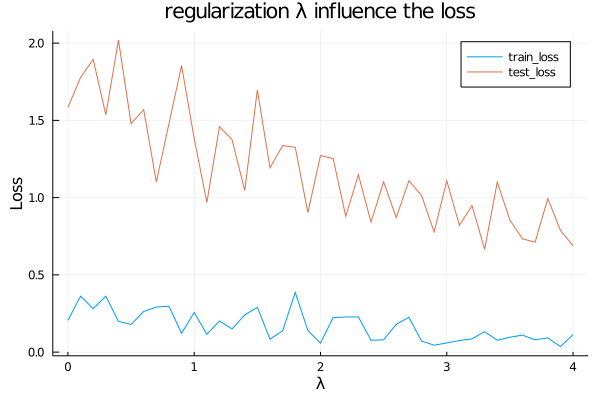

In [76]:
plot(0:0.1:4, [train_loss test_loss], label=["train_loss" "test_loss"], xlabel="λ", ylabel="Loss", title="regularization λ influence the loss")

As we can see, the coefficient of regularization is $\lambda$, if $0<\lambda<1$, we have high loss in test but at train set is great,absolutely, we overfitting train set. when the $\lambda$ become more larger, the test loss start to fall down 0.

## Dropout
In multilayer perceptron, we describe a multilayer perceptron with a single hidden layer, assuming that number of inputs is 4, and the number of hidden layer unit is 5. So

$$
h_i = \phi(x_1w_{1i} + x_2w_{2i} + x_3w_{3i}+x_4w_{4i} + b_i)
$$

among them, $\phi$ is activative function, $x_1,...x_4$ is input value, $w_{1i}, ..., w_{4i}$ is hidden layer parameters.

When use dropout way to this hidden layer, hidden units in this layer will have the chance to be dropped.set the probability is $p$. drop out don't change the expect.

Because in training process, hidden units will be dropped out by $p$, so output calculate can't rely too much on anyone in $h_1,..h_5$.

**For example:**

In [132]:
using BenchmarkTools
images = Flux.Data.FashionMNIST.images()
labels = Flux.Data.FashionMNIST.labels()
k = sort(unique(labels))
onehot_labels = Flux.onehotbatch(labels, klasses)
train_x = rand(784, 6000)
for i in 1:6000
	train_x[:,i] = Float64.(reshape(images[i],(784,1)))
end
train_data = Flux.Data.DataLoader(Array(train_x[:, 1:4000]), Array(onehot_labels[:, 1:4000]), batchsize=10, shuffle=true)
#dropout some layers
m = Chain(
    Dense(784, 256, relu),
    Dropout(0.2), 
    Dense(256, 256, relu), 
    Dropout(0.5), 
    Dense(256, 10, relu))
loss1(x, y) = Flux.logitcrossentropy(m(x), y)
opt = Descent(0.05)
ps = Flux.params(m)
@btime @epochs 10 Flux.train!(loss1, ps, train_data, opt)

┌ Info: Epoch 1
└ @ Main /Users/zhouzhuofei/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 2
└ @ Main /Users/zhouzhuofei/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 3
└ @ Main /Users/zhouzhuofei/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 4
└ @ Main /Users/zhouzhuofei/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 5
└ @ Main /Users/zhouzhuofei/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 6
└ @ Main /Users/zhouzhuofei/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 7
└ @ Main /Users/zhouzhuofei/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 8
└ @ Main /Users/zhouzhuofei/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 9
└ @ Main /Users/zhouzhuofei/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 10
└ @ Main /Users/zhouzhuofei/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 1
└ @ Main /Use

  12.838 s (158285277 allocations: 7.87 GiB)


In [135]:
accuracy(x, y, model) = Flux.mean(Flux.onecold(model(x)) .== Flux.onecold(y))
accuracy(Array(train_x[:, 1:4000]), Array(onehot_labels[:, 1:4000]), m)
accuracy(Array(train_x[:, 4000:6000]), Array(onehot_labels[:, 4000:6000]), m)

0.8600699650174912

## Numerical Stability and model initialization

**Vanishing** and **explosion**

when number of layers the neural network is large, the numerical stability of the model tends to deteriorate.